https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn/data

In [214]:
!pip install imbalanced-learn

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
from imblearn.over_sampling import SMOTE

import tensorflow as ts
from tensorflow import keras

%matplotlib inline

In [3]:
#https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn/data
df = pd.read_csv("data/Customer-Churn-Records.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [4]:
def drop_unwanted_columns(df, columns = ["RowNumber", "Surname", "CustomerId"]):
    df_col_droped = df.drop(columns, axis = 1)
    return df_col_droped

df_col_droped = drop_unwanted_columns(df)
df_col_droped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Geography           10000 non-null  object 
 2   Gender              10000 non-null  object 
 3   Age                 10000 non-null  int64  
 4   Tenure              10000 non-null  int64  
 5   Balance             10000 non-null  float64
 6   NumOfProducts       10000 non-null  int64  
 7   HasCrCard           10000 non-null  int64  
 8   IsActiveMember      10000 non-null  int64  
 9   EstimatedSalary     10000 non-null  float64
 10  Exited              10000 non-null  int64  
 11  Complain            10000 non-null  int64  
 12  Satisfaction Score  10000 non-null  int64  
 13  Card Type           10000 non-null  object 
 14  Point Earned        10000 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 1.1+

In [21]:
def analysis_graphs_non_cat(df, non_categorical_columns = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary", "Point Earned"], show = False):
    
    plt.figure(figsize=(15, 25))
    
    for i, col in enumerate(non_categorical_columns):
        # --- Absolute counts ---
        plt.subplot(len(non_categorical_columns), 2, i*2 + 1)
        stayed = df[df.Exited == 0][col]
        exited = df[df.Exited == 1][col]
        
        plt.hist([stayed, exited], color=['green', 'red'], label=['Stayed', "Exited"])
        plt.xlabel(col)
        plt.ylabel("Number of customers")
        plt.title(f"{col} vs Churn (Counts)")
        plt.legend()
    
        # --- Proportions ---
        plt.subplot(len(non_categorical_columns), 2, i*2 + 2)
        bins = np.linspace(df[col].min(), df[col].max(), 11)  # 10 bins
        counts_exited, _ = np.histogram(exited, bins=bins)
        counts_stayed, _ = np.histogram(stayed, bins=bins)
    
        total = counts_exited + counts_stayed
        total[total == 0] = 1  # avoid division by zero
    
        prop_exited = counts_exited / total
        prop_stayed = counts_stayed / total
    
        bin_centers = (bins[:-1] + bins[1:]) / 2
        width = (bins[1] - bins[0]) * 0.9
    
        plt.bar(bin_centers, prop_stayed, width=width, color="green", label="Stayed")
        plt.bar(bin_centers, prop_exited, width=width, bottom=prop_stayed, color="red", label="Exited")
        plt.xlabel(col)
        plt.ylabel("Proportion of customers")
        plt.title(f"{col} vs Churn (Proportional)")
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle("Customer Churn Analysis Across Features (Non Catogorical)", fontsize=20, y=1.02)
    plt.savefig("exports/churn_analysis_non_catogorical.pdf", bbox_inches="tight")
    print("churn_analysis_non_catogorical.pdf exported")
    if show == True : plt.show()

churn_analysis_non_catogorical.pdf exported


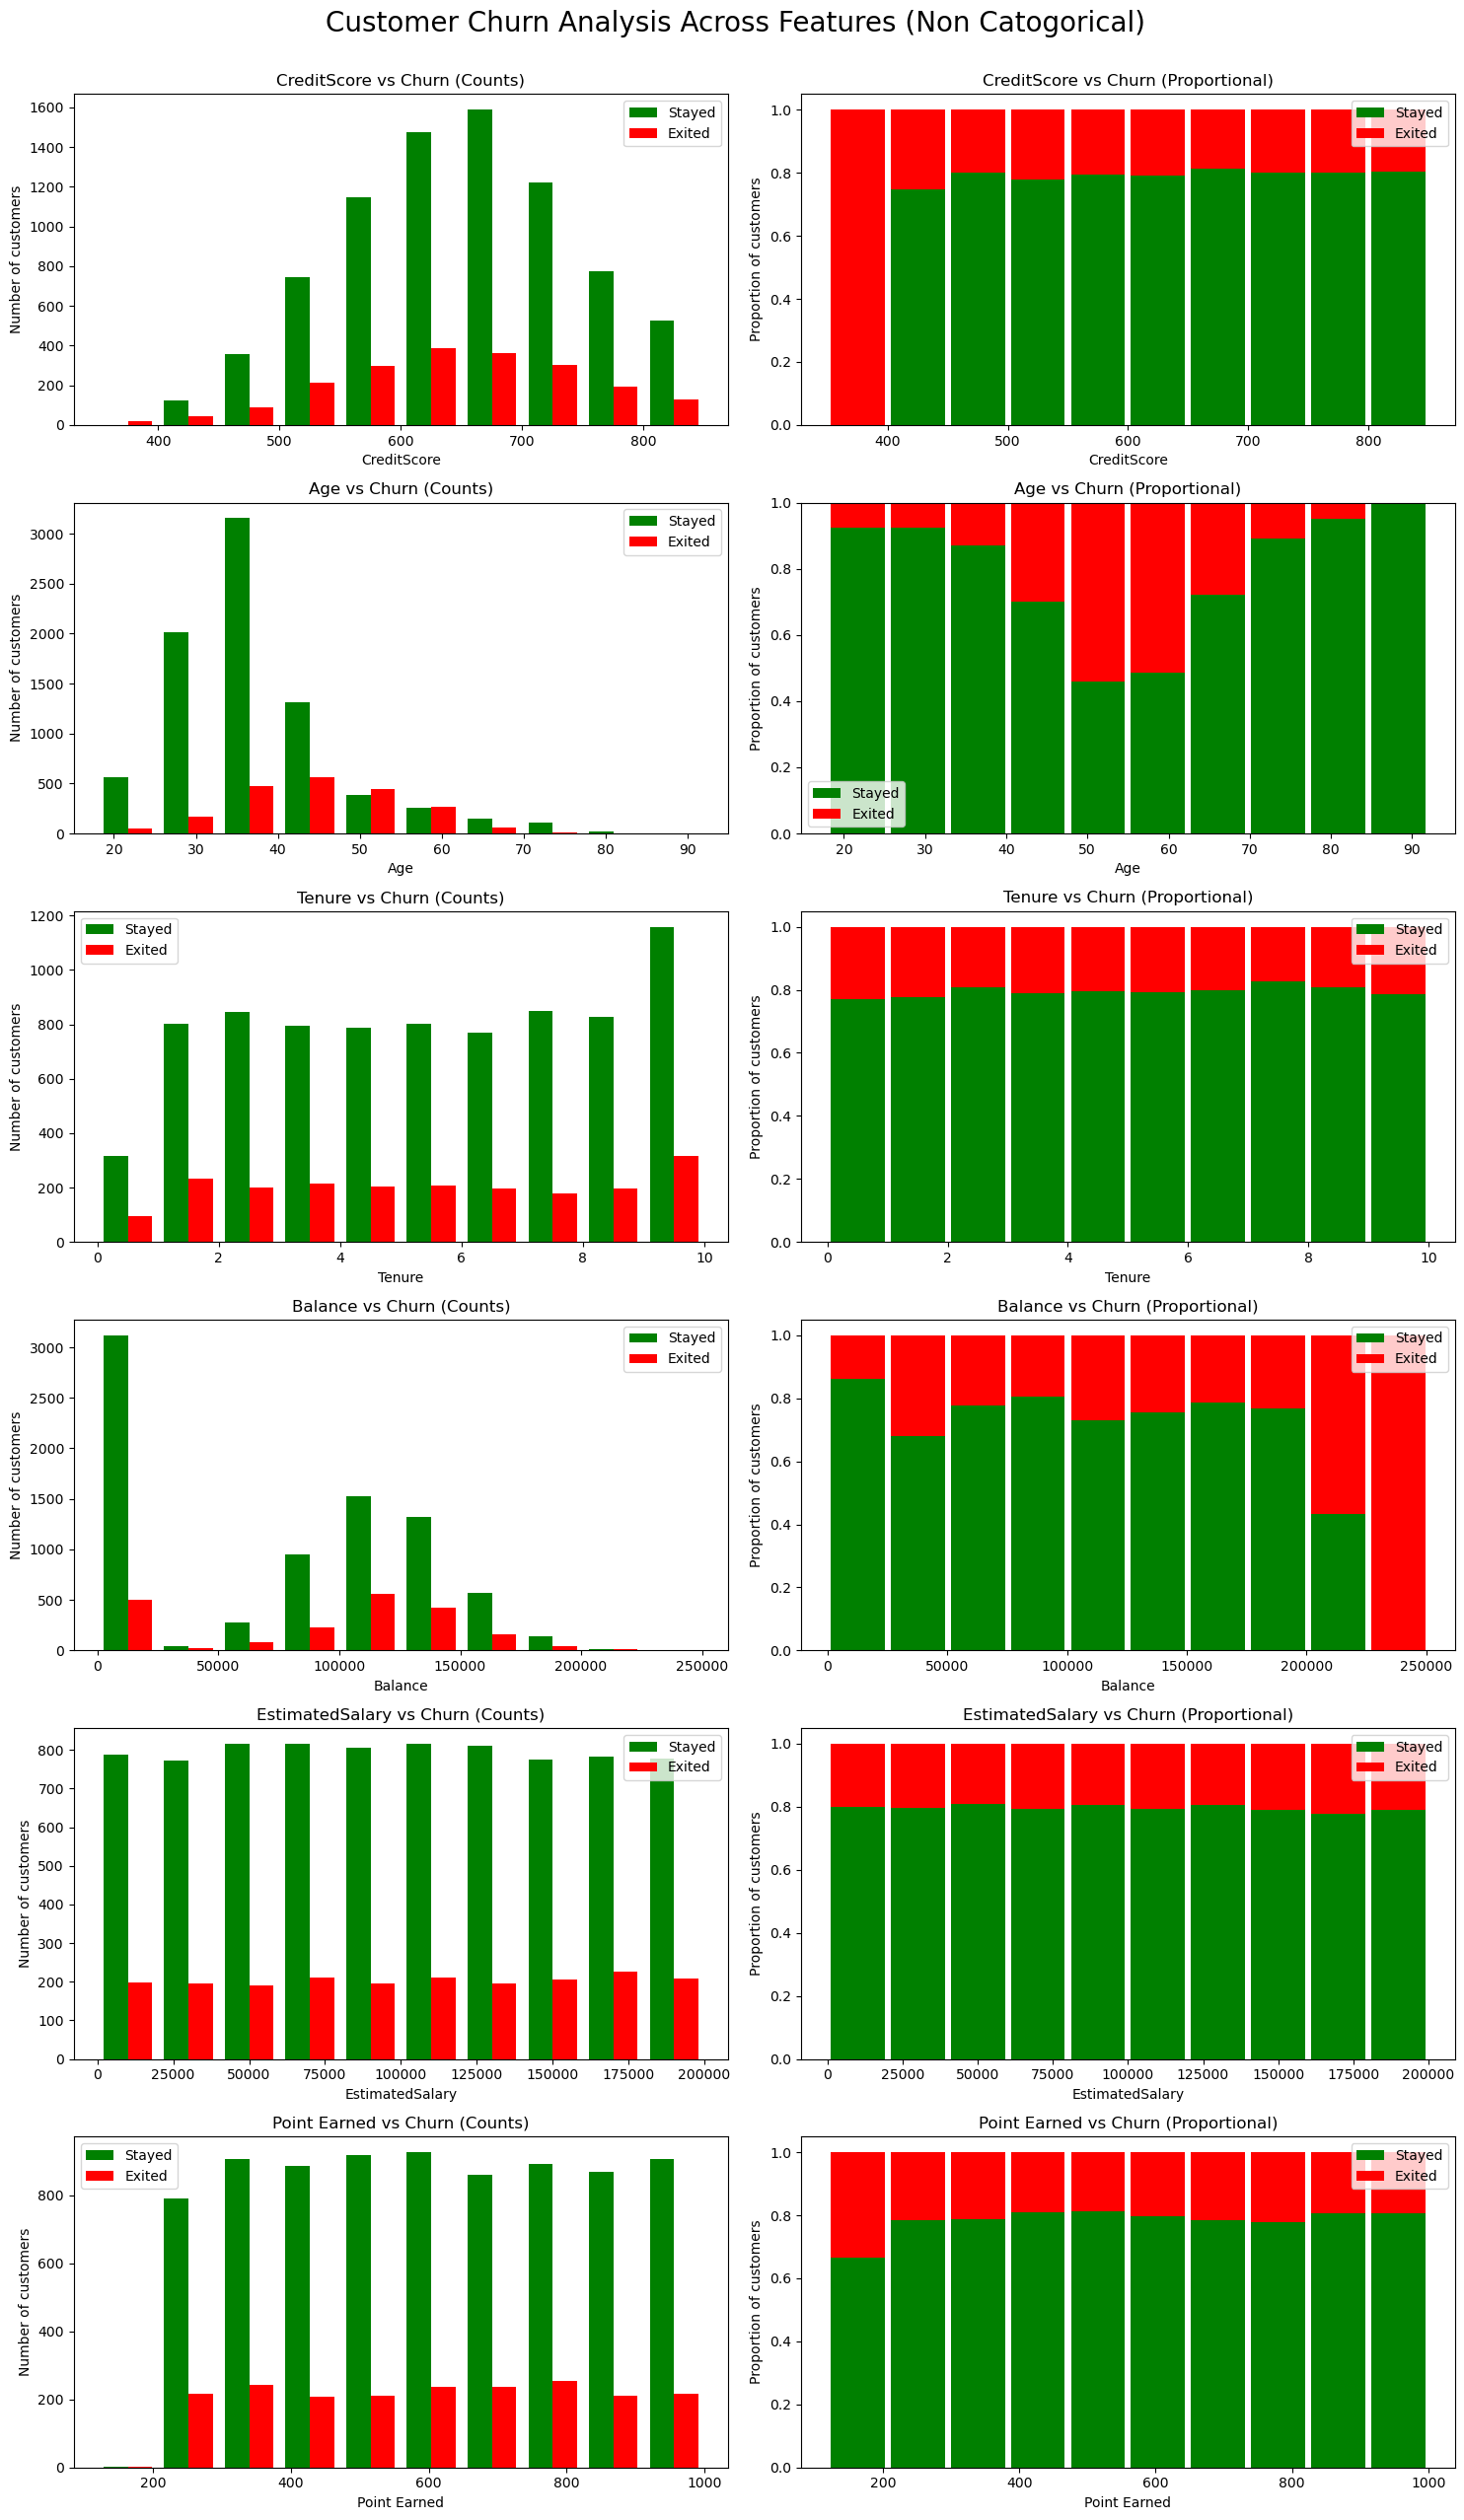

In [19]:
analysis_graphs_non_cat(df = df_col_droped, show = True)

In [33]:
def analysis_graphs_cat(df, categorical_columns = ["Geography", "Gender", "NumOfProducts", "HasCrCard", "IsActiveMember", "Complain", "Satisfaction Score", "Card Type"], show=False):
    
    plt.figure(figsize=(10, 20))
    
    for i, col in enumerate(categorical_columns):
        # --- Absolute counts ---
        plt.subplot(len(categorical_columns), 2, i*2 + 1)
        stayed = df[df.Exited == 0][col]
        exited = df[df.Exited == 1][col]
        
        plt.hist([stayed, exited], color=['green', 'red'], label=['Stayed', "Exited"])
        plt.xlabel(col)
        plt.ylabel("Number of customers")
        plt.title(f"{col} vs Churn (Counts)")
        plt.legend()
    
        # --- Proportions ---
        plt.subplot(len(categorical_columns), 2, i*2 + 2)
        geo_counts = df.groupby([col, "Exited"]).size().unstack(fill_value=0)
        
        stayed = geo_counts[0]
        exited = geo_counts[1]
        total = stayed + exited
        total[total == 0] = 1
        
        stayed_prop = stayed / total
        exited_prop = exited / total
        
        x = range(len(geo_counts.index))
        plt.bar(x, stayed_prop, color="green", label="Stayed")
        plt.bar(x, exited_prop, bottom=stayed_prop, color="red", label="Exited")
        
        plt.xticks(x, geo_counts.index)
        plt.xlabel(col)
        plt.ylabel("Proportion of customers")
        plt.title(f"{col} vs Churn (Proportional)")
        plt.legend()
    
    
    plt.suptitle("Customer Churn Analysis for Categorical Features (Catogorical)", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.savefig("exports/churn_analysis_catogorical.pdf", bbox_inches="tight")
    print("churn_analysis_catogorical.pdf exported")
    if show == True : plt.show()

churn_analysis_catogorical.pdf exported


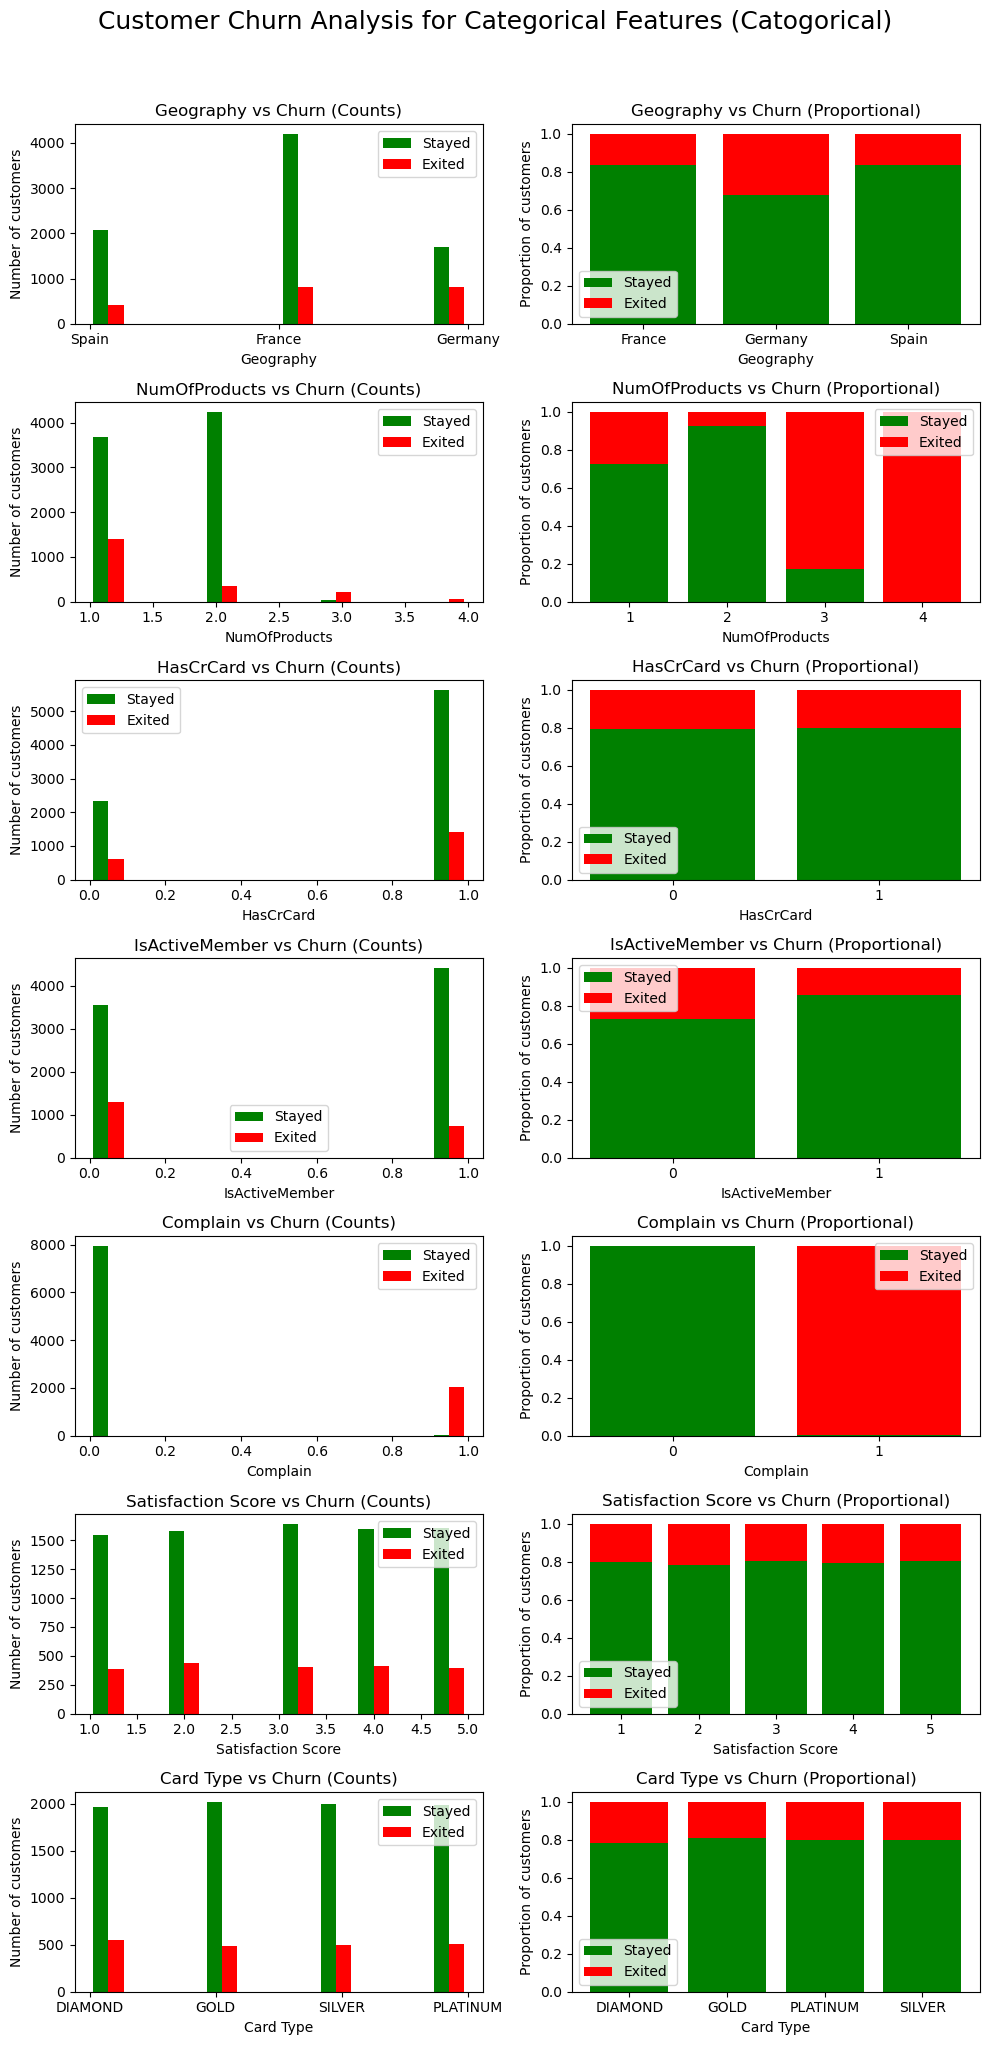

In [8]:
analysis_graphs_cat(df = df_col_droped, show=True)

In [56]:
categorical_columns = ["Geography", "Gender", "NumOfProducts", "HasCrCard", "IsActiveMember", "Complain", "Satisfaction Score", "Card Type"]

for i in categorical_columns:
    print(f"{i} : {df_col_droped[i].unique()}")

Geography : ['France' 'Spain' 'Germany']
Gender : ['Female' 'Male']
NumOfProducts : [1 3 2 4]
HasCrCard : [1 0]
IsActiveMember : [1 0]
Complain : [1 0]
Satisfaction Score : [2 3 5 4 1]
Card Type : ['DIAMOND' 'GOLD' 'SILVER' 'PLATINUM']


In [58]:
def convert_dummy_features(df, columns = ["Geography", "Gender", "Card Type"]):
    return pd.get_dummies(data=df, columns=columns, dtype=int)

In [60]:
df_with_dummies = convert_dummy_features(df = df_col_droped)
df_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Age                 10000 non-null  int64  
 2   Tenure              10000 non-null  int64  
 3   Balance             10000 non-null  float64
 4   NumOfProducts       10000 non-null  int64  
 5   HasCrCard           10000 non-null  int64  
 6   IsActiveMember      10000 non-null  int64  
 7   EstimatedSalary     10000 non-null  float64
 8   Exited              10000 non-null  int64  
 9   Complain            10000 non-null  int64  
 10  Satisfaction Score  10000 non-null  int64  
 11  Point Earned        10000 non-null  int64  
 12  Geography_France    10000 non-null  int64  
 13  Geography_Germany   10000 non-null  int64  
 14  Geography_Spain     10000 non-null  int64  
 15  Gender_Female       10000 non-null  int64  
 16  Gende

In [68]:
def scaller_train(df, non_categorical_columns = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary", "Point Earned"]):
    scaller = MinMaxScaler()
    scaller.fit_transform(df[non_categorical_columns])
    joblib.dump(scaller, 'exports/minmax_scaler.joblib')

def scaller_scale(df, non_categorical_columns = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary", "Point Earned"]):
    loaded_scaler = joblib.load('exports/minmax_scaler.joblib')
    df[non_categorical_columns] = loaded_scaler.transform(df[non_categorical_columns])
    return df

In [92]:
non_categorical_columns = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary", "Point Earned"]

scaller_train(df = df_with_dummies)
df_scalled = scaller_scale(df = df_with_dummies)

df_scalled[non_categorical_columns].describe()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Point Earned
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.601058,0.282727,0.501280,0.304848,0.500441,0.553366
std,0.193307,0.141727,0.289217,0.248696,0.287580,0.256441
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.468000,0.189189,0.300000,0.000000,0.254977,0.330306
50%,0.604000,0.256757,0.500000,0.387402,0.500960,0.551646
75%,0.736000,0.351351,0.700000,0.508749,0.746955,0.774120
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [96]:
df_scalled.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
       'Satisfaction Score', 'Point Earned', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male',
       'Card Type_DIAMOND', 'Card Type_GOLD', 'Card Type_PLATINUM',
       'Card Type_SILVER'],
      dtype='object')

In [110]:
X = df_scalled.drop(["Exited"], axis = 1)
y = df_scalled["Exited"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)

(8000, 20)


In [242]:
def preprocessing(X, y, isTrain):
    df1 = drop_unwanted_columns(X, columns = ["RowNumber", "Surname", "CustomerId"])
    df2 = convert_dummy_features(df1, columns = ["Geography", "Gender", "Card Type"])
    if isTrain : scaller_train(df2, non_categorical_columns = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary", "Point Earned"])
    df3 = scaller_scale(df2, non_categorical_columns = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary", "Point Earned"])
    smote = SMOTE(sampling_strategy='minority')
    X_sm, y_sm = smote.fit_resample(df3, y)
    return X_sm, y_sm

In [244]:
df.shape

(10000, 18)

In [248]:
X = df.drop(["Exited"], axis = 1)
y = df["Exited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

X_train_processed, y_train_processed = preprocessing(X_train, y_train, isTrain=True)
X_test_processed, y_test_processed = preprocessing(X_test, y_test, isTrain=False)

print(X_train_processed.shape)
print(X_test_processed.shape)

(12740, 20)
(3184, 20)


In [260]:
model = keras.Sequential([
    keras.layers.Input(shape=(20,)),
    keras.layers.Dense(20, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(X_train_processed, y_train_processed, validation_split=0.2, epochs=50)

Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.8134 - loss: 0.4837 - val_accuracy: 0.9984 - val_loss: 0.1810
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.9986 - loss: 0.1072 - val_accuracy: 0.9984 - val_loss: 0.0556
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.9984 - loss: 0.0478 - val_accuracy: 0.9984 - val_loss: 0.0387
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.9978 - loss: 0.0393 - val_accuracy: 0.9984 - val_loss: 0.0343
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.9987 - loss: 0.0308 - val_accuracy: 0.9984 - val_loss: 0.0305
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.9982 - loss: 0.0301 - val_accuracy: 0.9984 - val_loss: 0.0289
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.9987 - loss: 0.0256 - val_accuracy: 0.9984 - val_loss: 0.0244
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.9986 - loss: 0.0242 - 

In [261]:
model.evaluate(X_test_processed, y_test_processed)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.9992 - loss: 0.0090


[0.013522670604288578, 0.9984296560287476]

In [262]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test_processed)

# Step 2: Convert probabilities to class labels (0 or 1)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Step 3: Print the classification report
print(classification_report(y_test_processed, y_pred_classes))

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00      1592

    accuracy                           1.00      3184
   macro avg       1.00      1.00      1.00      3184
weighted avg       1.00      1.00      1.00      3184



In [208]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
       'Satisfaction Score', 'Card Type', 'Point Earned'],
      dtype='object')

In [210]:
df[df.Exited == 0].shape

(7962, 18)

In [212]:
df[df.Exited == 1].shape

(2038, 18)

In [240]:
smote = SMOTE(sampling_strategy='minority')
x = preprocessing(X, isTrain=True)
X_sm, y_sm = smote.fit_resample(x, y)
a = [y_sm > 0]
b = [y_sm < 1]
print(len(a[0]), len(b[0]))

15924 15924


In [258]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_processed, y_train_processed)
y_pred_lr = log_reg.predict(X_test_processed)
print(classification_report(y_test_processed, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00      1592

    accuracy                           1.00      3184
   macro avg       1.00      1.00      1.00      3184
weighted avg       1.00      1.00      1.00      3184



In [266]:
import pandas as pd
corr = df.corr()['Exited'].sort_values(ascending=False)
print(corr)

ValueError: could not convert string to float: 'Hargrave'